# Assignment 3 - Supervised classification applied on traffic data 
<hr>

Traffic congestion is everywhere. Here, we provide three different perspectives of a congestion - traveler's, traffic at a given moment mapped on a GIS map and in the form of a space-time speed map (space-time map is explained in the video). 
<img src="traffic jam.png">

There are different kinds of traffic congestions, which could be attributed to different causes. For example, if somebody makes a sudden break at a highway, it can create the first pattern given below whereas the second pattern is the congestion caused because of a huge fire near the Schipol tunnel in 2017.
<img src="examples.png">

Thus, if we can group these different types of congestion and add context to these groups, we can use it for diagnostic and prediction purposes. For eg. if all the patterns in a group are caused by heavy rainfall, we can classify them. Thus, given the current traffic state and the weather, we can predict how the congestion will evolve and hence mitigate them. But for this, we first need to classify. In literature, the congestion are mainly categorised into 6 groups and hence the data is also manually classified into these 6 classes. And you are going to build a classifier for these congestion types in this assignment.

## Data


The speed and flow data is collected from the A13 highway corridor in the Netherlands using loop detectors for the months of October from 2012 to 2020. We estimate the travel time for the corridor from speed and flow. The speed and flow data has been used during the course and for the assignment, you will be working with the travel time. The structure of the pandas dataframe is as follows:

- **id**: pattern id
- **date**: measurement date
- **speed**: speed matrix of size space X time, speed is measured every 30 seconds
- **flow**: flow matrix of size space X time, flow is measured every 30 seconds
- **space**: relative distance of the highway corridor sampled every 200 meters
- **time**: measurement time resolution of speed and flow
- **travel_time**: estimated travel time of the corridor at specific time
- **travel_time_time**: time resolution of estimated travel time
- **label**: manually classified label of the congestion patterns

The relevant features are date, travel_time, travel_time_time, label

NOTE: The manual classification was done based on the speed matrix. The time aggregation of the travel time data is different from the aggregation of the speed and flow data. Account for this if you use speed and flow for your analysis.

<img src="input.png">

## Instruction

The tasks are defined in each section. 
- Implement the solutions using code cells and write your analysis using markdown cells. 
- Once you have completed everything, remember to restart the kernel and run all cells again. Make sure there are no errors. 
- Save the notebook (replace XX in the filename with your group number). 
- Export a HTML version of the notebook. Hint: Menu -> File -> Download as -> HTML. 
- Submit both the notebook (.ipynb) and the export (.html)

## Justify all you answers with code or visualisations or numbers! Max 200 words per answer!

<hr>

In [3]:
#all library imports
%matplotlib inline
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Text(0.5, 1.0, 'Travel Time')

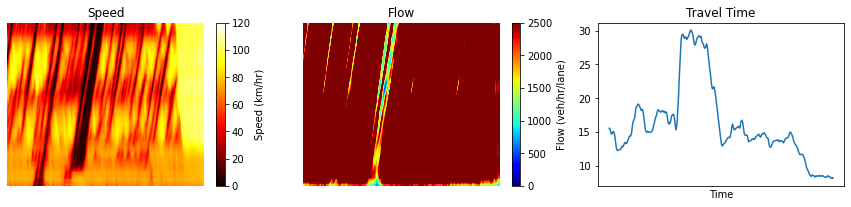

In [4]:
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 0

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

## Task 1 - Data Preprocessing

QUESTION 1: Is the raw travel time sufficient to distinguish between the six classes?
Hint: Use TSNE or LDA

In [5]:
# check for imballance in the number of measurements each day
# and get the smallest number of measurments
len_lst = []
for data_per_day in dataset['travel_time']:
    len_lst.append(len(data_per_day))
num_resize = min(len_lst)

# the size of matrix are different size for the samples, so resize raw data 
def raw_features_resized(speed):
  return speed[:num_resize]
dataset['travel_time_resized'] = dataset['travel_time'].apply(raw_features_resized)

[Text(0.5, 1.0, 'LDA')]

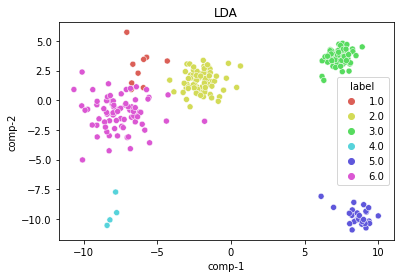

In [6]:
# Perform feature reduction on the raw (resized) traveltime data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = np.stack(dataset['travel_time_resized'])
y = dataset['label'].to_numpy()

lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, y).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

To answer this question, the LDA feature reduction method is used. The travel time is first resized such that all measurement days contain the same number of time measurements. This resized raw data is then reduced to 2 features. The plot resulting from this feature reduction, including the spread in classification data can be seen above. Here it can be seen no classes overlap. Still classes 1, 2, and 6 are seen to lie directly next to each other, making the classification between these classes more difficult. This could possibly be improved, as will be seen next.

QUESTION 2: The travel time of a day have an aggregation of one minute. Is this time aggregation of the dataset necessary? Or can you aggregate the data further in time for the classification? 

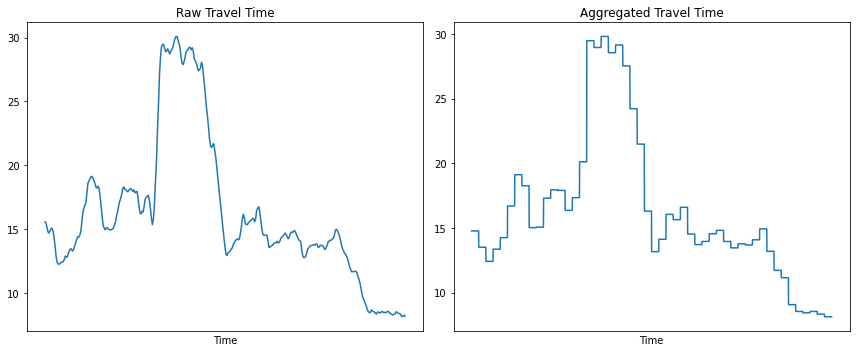

In [7]:
# aggregate the traveltime data
import cv2

day = 0
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# raw travel time plot
axes[0].plot(dataset.iloc[day].travel_time_time, dataset.iloc[day].travel_time)
axes[0].set_xticks([])
axes[0].set_xlabel('Time')
axes[0].set_title('Raw Travel Time')

# aggregated travel time plot
img_aggr = cv2.resize(np.array(dataset.iloc[day].travel_time), (50, 50))
time_trace = img_aggr.flatten()
axes[1].plot(time_trace)
axes[1].set_xticks([])
axes[1].set_xlabel('Time')
axes[1].set_title('Aggregated Travel Time')

plt.tight_layout()
plt.show()

By using the cv2 package, the raw travel time can be further aggregated. This aggregation results in a new 'low-resolution' plot of the travel_time. This new plot does lack some detailed information, however, it also filters out noise in the data which potentially affects the classifier negatively. Choosing an appropriate aggregation value is therefore done by means of trial-and-error and trhough evaluating the subsequent spread in clusters that follows from the LDA dimension reduction. The results of this is further described in next question.

QUESTION 3: Does the aggregated travel time data sufficient to distinguish between the six classes. 

In [8]:
# aggregate data
def aggregate(item):
  return cv2.resize(np.array(item), (250, 250)).flatten()
dataset["travel_time_resized_agg"] = dataset['travel_time_resized'].apply(aggregate)

X_agg = np.stack(dataset["travel_time_resized_agg"])

lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X_agg, y).transform(X_agg)
dataset["comp-1_agg"] = X_r[:,0]
dataset["comp-2_agg"] = X_r[:,1]

Text(0.5, 1.0, 'Aggregated travel time feature detection')

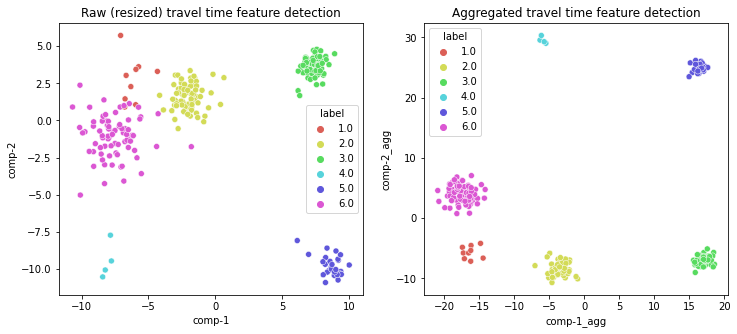

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset, ax=axes[0]).set(title="LDA")
axes[0].set_title('Raw (resized) travel time feature detection')

sns.scatterplot(x="comp-1_agg", y="comp-2_agg", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset, ax=axes[1]).set(title="LDA")
axes[1].set_title('Aggregated travel time feature detection')

Through trial-and-error, the value used to aggregate the data is new dimension of (250, 250). This is equivalent to a new aggregated travel time of 1.316 minute. Subsequently, this aggregated travel time is reduced in features using LDA with 2 features. The final spread of each cluster is then plotted, next to plot of the raw resized travel time, as described in part 1. It becomes clear that the new features from the aggregated data do much clearer distinguish between the six classes.

## Bonus Question - High level features

QUESTION 4: Extract high-level features from the travel time dataset using any method or detector. Visualise the output of the detector with an example travel time vector.

Low-level features: features such as edges and blobs in the data, not so meaningfull but easy to detect. These features are based signal/image processing techniques. 
<br> High-level features: objects & events. These features are based on machine learning techniques. 
<br> In general, low-level features are used to extract high-level features. 

<br> To extract high-level features, Singular Spectrum Analysis was chosen do decompose the signal into two components. 

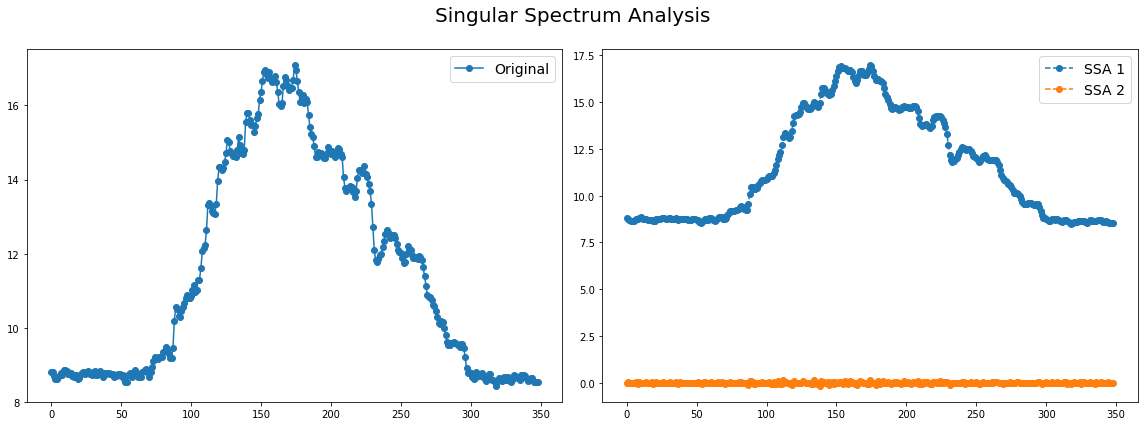

In [10]:
X = pd.DataFrame(dataset.travel_time.tolist()).values
X = np.delete(X, [19, 58, 117, 213, 247], axis=0)    # remove rows with NaN components 
X = X[:,:-4]   # remove last values due to NaN 


from pyts.decomposition import SingularSpectrumAnalysis

window_size = 2

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=window_size)
X_ssa = ssa.fit_transform(X)

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(X[5], 'o-', label='Original')
# ax2.plot(X_ssa[0, 0, :], 'o--', label='SSA')
ax1.legend(loc='best', fontsize=14)


ax2 = plt.subplot(122)
for i in range(window_size):
    ax2.plot(X_ssa[5,i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


#Answer

QUESTION 5: Is the high-level features sufficient to distinguish between the six classes. 

Text(0, 0.5, 'SSA2')

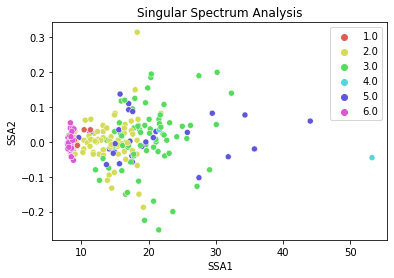

In [11]:
# plot all of the high features 
labels = np.delete(dataset['label'].to_numpy(), [19, 58, 117, 213, 247], axis=0)  

k = 150 # plot a point halfway the time series 
plt.figure()
sns.scatterplot(x=X_ssa[:,0,k], y=X_ssa[:,1,k], hue=labels,
                palette=sns.color_palette("hls", 6)).set(title="Singular Spectrum Analysis")
plt.xlabel('SSA1')
plt.ylabel('SSA2')


Some of the classes can be recognized when using the high-level features, such as class 6 which appears on the left. After that class 2 also roughly forms a cluster but class 3 and 5 can not be distinguished from each other using this method. 

In this case the time series was decomposed into only two components, using more SSA components might give better results, but this was not further investigated. 

## Task 2 - Probablistic Classifier

QUESTION 6: Divide the dataset into test, train and validation dataset. Build a logistic classifier for the dataset. Use leave-one-out validation strategy for the classifier. Justify the parameter selection

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X = np.stack(dataset['travel_time_resized'])
Y = dataset['label']
rand_seed = 1
X_train, _X, Y_train, _Y = train_test_split(X, Y, train_size=0.5, stratify=Y, random_state=rand_seed)
X_validate, X_test, Y_validate, Y_test = train_test_split(_X, _Y, train_size=0.5, stratify=_Y, random_state=rand_seed)

In [13]:
def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 3))
    sns.heatmap(logreg_conf, annot=True, fmt='.0%', cmap='Blues')
    plt.show()

For Logistic Regression l2 regression is default. C is the inverse of regulation strength. Smaller values specify stronger regularization. Max_iter default = 100, number of iterations taken for the solvers to converge. 

In [14]:
C_values = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
max_iterations = [250, 500, 1000, 1500, 2000]

In [15]:
def calculate_diagonal(matrix):
    numb = len(matrix)
    predicted_correctly = 0
    
    for i in range(len(matrix)):
        predicted_correctly += matrix[i][i]
    #print("score for C_value", C_value, "is:", (predicted_correctly/numb)*100)
    return((predicted_correctly/numb)*100)

In [16]:
values = {}
for i, C_value in enumerate(C_values):
    logreg = LogisticRegression(C=C_value, max_iter=1000)

    # Create an instance of Logistic Regression Classifier and fit the data.
    logreg.fit(X_train, Y_train)
    Ypred_test = logreg.predict(X_test)

    matrix = confusion_matrix(Y_test, Ypred_test, normalize='true')
    

    values[C_value] = calculate_diagonal(matrix)
    

C:\Users\Lotte\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lotte\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

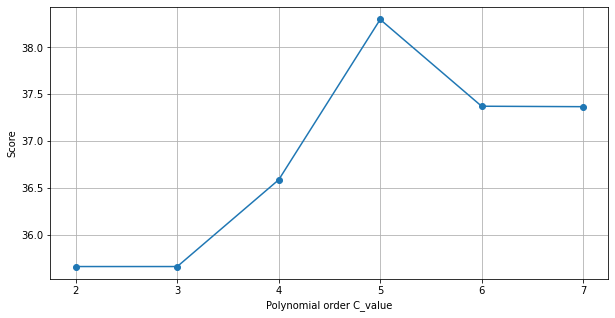

In [17]:
plt.figure(figsize=(10, 5))
plt.plot([2,3,4,5,6,7], list(values.values()), 'o-')
plt.xticks([2,3,4,5,6,7])
plt.xlabel('Polynomial order C_value')
plt.ylabel('Score')
plt.grid()

In [18]:
values_iter = {}
for i, max_iteration in enumerate(max_iterations):
    logreg = LogisticRegression(C=1e5, max_iter=max_iteration)

    # Create an instance of Logistic Regression Classifier and fit the data.
    logreg.fit(X_train, Y_train)
    Ypred_test = logreg.predict(X_test)

    matrix = confusion_matrix(Y_test, Ypred_test, normalize='true')
    

    values_iter[max_iteration] = calculate_diagonal(matrix)

C:\Users\Lotte\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lotte\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

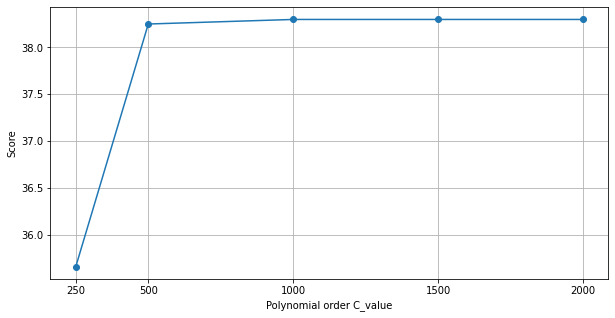

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(max_iterations, list(values_iter.values()), 'o-')
plt.xticks(max_iterations)
plt.xlabel('Polynomial order C_value')
plt.ylabel('Score')
plt.grid()

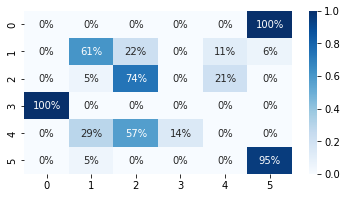

In [20]:
logreg = LogisticRegression(C=1e5, max_iter=1000)

# logreg = LogisticRegression(C=1e5, max_iter=1000)
# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, Y_train)
Ypred_test = logreg.predict(X_test)
show_conf_matrix(Y_test, Ypred_test)

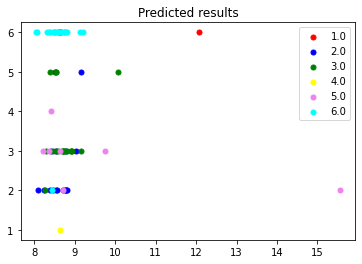

In [21]:
# show logistic regression model
cdict = {1: 'red', 2: 'blue', 3: 'green', 4: 'Yellow', 5: 'violet', 6: 'cyan'}

fig, ax = plt.subplots()
for g in np.unique(Y_test):
    ix = np.where(Y_test == g)
    ax.scatter(X_test[ix,0], Ypred_test[ix], c = cdict[g], label = g, s = 25)
ax.legend()
plt.title('Predicted results')
plt.show()




In the graph above, the predicted results are shown, the colour of each observation is the group it actually belongs to. 

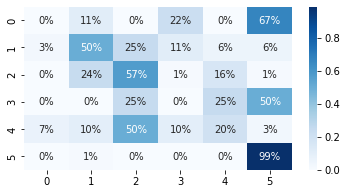

In [22]:
import warnings
warnings.filterwarnings("ignore")

# Use leave one out cross validation 
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.split(X, Y)

Ypred_test_loo = np.zeros((len(Y)))

for train_index, test_index in loo.split(X,Y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_loo, X_test_loo = X[train_index], X[test_index]
    Y_train_loo, Y_test_loo = Y[train_index], Y[test_index]
    logreg.fit(X_train_loo, Y_train_loo)
    Ypred_test_loo[test_index] = logreg.predict(X_test_loo)
    # print(X_train, X_test, y_train, y_test)
# check al sets for the classifier

show_conf_matrix(Y, Ypred_test_loo)

QUESTION 7: Evaluate the classification results with atleast 2 metrics. Justify your choice of metric.  

In question 6, the confusion matrix is already used as a metric. The diagonal of the confusion matrix shows the percentage of samples that are correctly classified. As a second metric, we will chose between accurancy, recall, precision and F-1 score. As can be seen in the cell below, we are dealing with a unbalanced dataset. Therefore, we will not use accurancy as a metric but F1 score. The F1 is a trade-off between precision and recall. In this case, the precision and recall are evenly important, this is also a reason to take the F1-score.

In [23]:
Y.value_counts()

6.0    77
3.0    75
2.0    72
5.0    30
1.0     9
4.0     4
Name: label, dtype: int64

In [24]:
from sklearn.metrics import precision_recall_fscore_support
from tabulate import tabulate

# Precision, Recall, F1-score
metrics_LR = precision_recall_fscore_support(Y_test, Ypred_test, beta=1, average='weighted')

metrics_LOO = precision_recall_fscore_support(Y, Ypred_test_loo, beta=1, average='weighted')

print(tabulate([['F1-score', metrics_LR[2], metrics_LOO[2]]], headers=['Metric', 'Logistic Classifier', 'LeaveOneOut']))                

Metric      Logistic Classifier    LeaveOneOut
--------  ---------------------  -------------
F1-score               0.642848       0.595067


QUESTION 8: Comment on the statistics of the probabilities in majority and minority classes

Text(0.5, 0, 'Class')

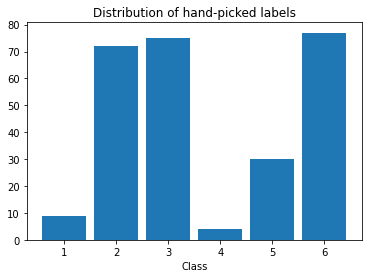

In [25]:
# show how big each class is 
# bins = [1, 2, 3, 4]
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]

plt.figure()
plt.hist(Y, bins=bins, rwidth=0.85)
plt.title('Distribution of hand-picked labels')
plt.xlabel('Class')

The minority classes are one and four, which both have less than 10 data points. Class two, three and six are represented quite well in the data. 

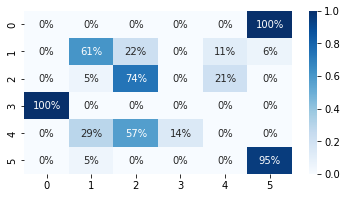

In [26]:
show_conf_matrix(Y_test, Ypred_test)

Text(0, 0.5, 'Probability')

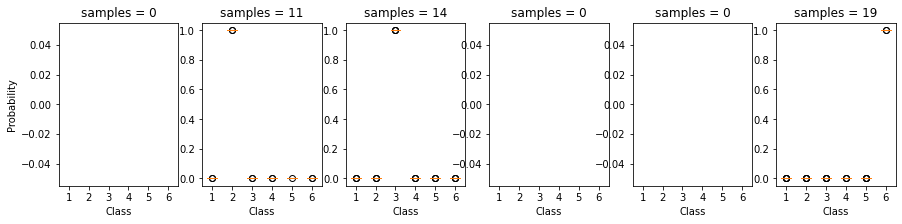

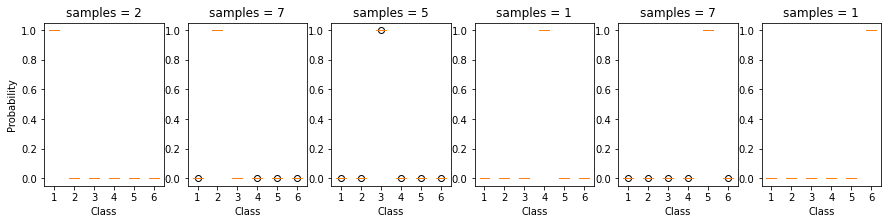

In [27]:
# Probability distribution in each class
is_correctly_classified = Y_test == Ypred_test
probabilities = logreg.predict_proba(X_test)
probabilities_correct = probabilities[is_correctly_classified]
probabilities_wrong = probabilities[~is_correctly_classified]

#Correctly classified
fig, ax = plt.subplots(1,6, figsize=(15,3))
for i in range(6):
    temp = probabilities[(Y_test == Ypred_test) & (Y_test == (i+1))]
    ax[i].boxplot(temp)
    ax[i].set_xlabel('Class')
    ax[i].set_title('samples = '+ str(len(temp)))
ax[0].set_ylabel('Probability')

#Wrongly classified
fig, ax = plt.subplots(1,6, figsize=(15,3))
for i in range(6):
    temp = probabilities[(Y_test != Ypred_test) & (Y_test == (i+1))]
    ax[i].boxplot(temp)
    ax[i].set_xlabel('Class')
    ax[i].set_title('samples = '+ str(len(temp)))
ax[0].set_ylabel('Probability')

In the plot above, the probabilities of a sample classified in a certain class are visualized. The upper six plots show the correctly classified samples and the lower six plots the wrongly classified plots. The plots match with the matrix, since it can be seen that the class 1, 4 and 5 have no correct predictions. In class three, the correctly classified samples have a probability of 100% to be predicted in the right class. In class 1, it can be seen that all the samples are classified in the wrong class, namely class 6. 

## Task 3 - Random Forest Classifier

QUESTION 9: Build a random forest classifier for the dataset. Use k-fold validation strategy for the classifier

First, the k-fold validation strategy for the training is implemented. Here a k value of 10 is chosen.

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

def k_fold_training(X_train, model, k, verbal=False):
    # Setup the k-fold cross-validation
    CV = KFold()
    CV.n_splits     = k     # k
    CV.shuffle      = True
    CV.random_state = 1

    # Train clf k times on k different data splits (k-fold cross validation)
    for train_index, test_index in CV.split(X_train):
        X_train_cv, X_test_cv = X[train_index, :], X[test_index, :]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred_values_cv = model.predict(X_test_cv)

        acc = accuracy_score(y_test_cv, y_pred_values_cv)
        print(f'Accuracy score: {acc.round(3)}') if verbal else None

    return model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Get input and output data; X and y
X_var = 'travel_time_resized'
X = np.stack(dataset[X_var])
y = dataset['label']

# # Get input and output data; X and y,   Make use of the feature reduced travel time data
# X_var = 'travel_time_resized_agg'
# X = np.stack(dataset[X_var])
# y = dataset['label']
# X = lda.fit(X, y).transform(X)

# Split data into a train, test, and validation set
X_train, _X, y_train, _y = train_test_split(X, y, train_size=0.5, random_state=1)
X_validate, X_test, y_validate, y_test = train_test_split(_X, _y, train_size=0.5, random_state=1)

# Define the random forest classifier as clf
clf = RandomForestClassifier()
clf.n_estimators = 125
clf.max_depth    = 20
clf.random_state = 1

# Perform the k-fold cross-validation training
k = 10
clf = k_fold_training(X_train, clf, k, verbal=True)


Accuracy score: 0.857
Accuracy score: 0.929
Accuracy score: 0.429
Accuracy score: 0.769
Accuracy score: 0.615
Accuracy score: 0.846
Accuracy score: 0.769
Accuracy score: 0.615
Accuracy score: 0.769
Accuracy score: 0.692


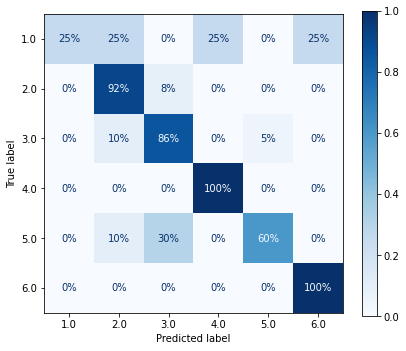

              precision    recall  f1-score   support

         1.0       1.00      0.25      0.40         4
         2.0       0.73      0.92      0.81        12
         3.0       0.82      0.86      0.84        21
         4.0       0.67      1.00      0.80         2
         5.0       0.86      0.60      0.71        10
         6.0       0.95      1.00      0.97        18

    accuracy                           0.84        67
   macro avg       0.84      0.77      0.76        67
weighted avg       0.85      0.84      0.82        67



In [30]:
from sklearn.metrics import plot_confusion_matrix, classification_report

fig, ax = plt.subplots(1, figsize=(6, 5))
plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap='Blues', ax=ax, values_format='.0%') 
plt.tight_layout()
plt.show()

y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

The random forest classifier is seen to have an overal good performance, indicated by the high values in the diagonal of the confusion matrix.

The classes with best performance are classes 4 and 6. This can be concluded from the high values in both precision and recall, and thereby f1-score.

The classes with lower performance are classes 1 and 5. For class 1, the classifier is able to detect 1 out of 4 labels correctly (recall of 0.25). Still, class 1 has a precision score of 1. This indicates that when the classifier classifies an input as class 1, that it can be concluded that this class is class 1 with 100% certainty. The f1 score of 0.4 balances these two aspects, where the 100% certainty of the output is balanced by the classifier missing various class 1 instances.

QUESTION 10: Conduct a sensitivity analysis of atleast two parameters of the random forest decision trees. Note: You dont need to find the optimal parameters but should conduct a sensitivity analysis.

In [31]:
from sklearn.metrics import accuracy_score

sensitivity = {'n_estimators':  np.arange(10, 200 +5, 5),
               'max_depth':     np.arange( 1,  20 +1, 1)}

accuracy_dict = {}
for item in sensitivity.keys():
    accuracy_dict[item] = []
    for value in sensitivity[item]:
        clf_val = RandomForestClassifier()
        clf_val.n_estimators = value if item == 'n_estimators' else 125
        clf_val.max_depth    = value if item == 'max_depth' else 20
        clf_val.random_state = 1

        clf_val.fit(X_train, y_train)   # train the validation model

        acc = accuracy_score(y_validate, clf_val.predict(X_validate))   # test the validation model
        accuracy_dict[item].append(acc)

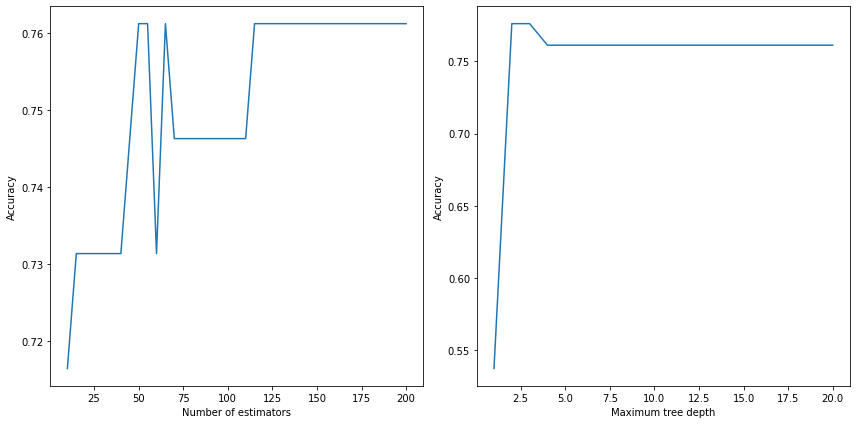

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(sensitivity['n_estimators'], accuracy_dict['n_estimators'])
axes[0].set_xlabel('Number of estimators')
axes[0].set_ylabel('Accuracy')

axes[1].plot(sensitivity['max_depth'], accuracy_dict['max_depth'])
axes[1].set_xlabel('Maximum tree depth')
axes[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

The two parameters that are chosen for the sensitivity analysis are:

    1. number of estimators, 
    2. maximum depth of tree

For the number of estimators, it can be seen that the accuracy increases for a larger number of estimators. Still, some irregularities are observed, which can be attributed to the random nature in which the trees are structued. These irregularities are seen to be removed when increasing the number of estimators/trees. It can be concluded that the maximum accuracy is attained when using at least 120 number of estimators.

For the maximum tree depth, a constant relation to the accuracy can be observed for a value larger than 4. From this analysis, it can therefore be concluded that for this dataset, the accuracy is left unchanged when increasing the tree depth to values larger than 4. It can also be observed that for values smaller than 7, the accuracy is affected. This indicates that the random forest classifier is actualy constrained by this value. It should also be noted that the maximum accuracy is obtained when constraining the maximum tree depth to values of 2 or 3. These values may therefore be further investigated as to what results they could give.

QUESTION 11: Analyse one of the pattern that is wrongly classified and explain why you think it is wrongly classified?

There are 11 false classifications


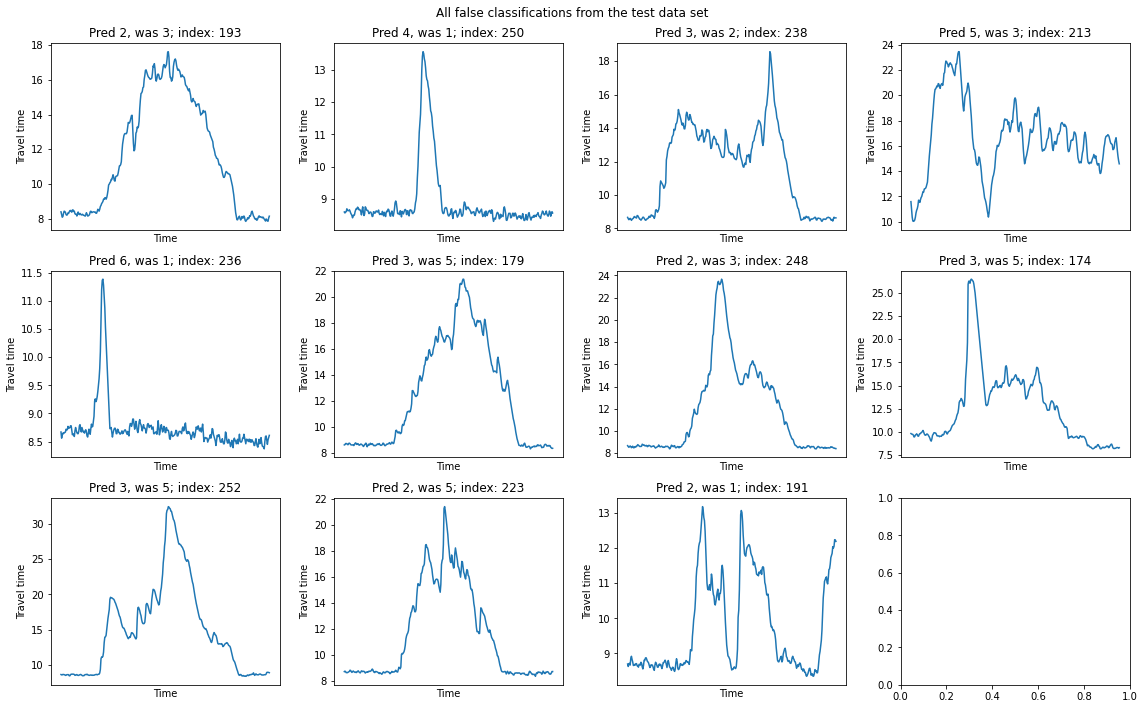

In [33]:
false_pred_bool = (y_test != y_pred_test)
false_pred_index = false_pred_bool[false_pred_bool].index.to_list()

num_false = false_pred_bool.sum()
print(f'There are {num_false} false classifications')

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('All false classifications from the test data set')
for i, index in enumerate(false_pred_index):
    class_pred = y_pred_test[false_pred_bool][i].astype(int)
    class_actu = dataset.loc[index, 'label'].astype(int)

    axes[i%3, i//3].plot(dataset.loc[index, X_var])
    axes[i%3, i//3].set_xticks([])
    axes[i%3, i//3].set_xlabel('Time')
    axes[i%3, i//3].set_ylabel('Travel time')
    axes[i%3, i//3].set_title(f'Pred {class_pred}, was {class_actu}; index: {index}')

plt.tight_layout()
plt.show()


The pattern that is analysed is the false classification of class 1 as class 6. This is seen to happen 1 time, and is characterised by a single, relatively small, peak in the travel time data.

To further understand the pattern of both classes 1 and 6, the travel time of the true labels are plotted. 

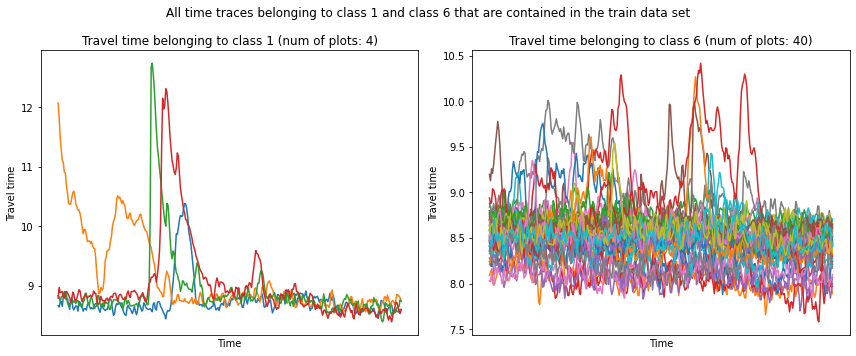

In [34]:
classes = [1, 6]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('All time traces belonging to class 1 and class 6 that are contained in the train data set')
for i, class_ in enumerate(classes):
    class_data = (y_train == class_)
    class_index = class_data[class_data].index.to_list()

    for j in class_index:
        axes[i].plot(dataset.loc[j, X_var])
    
    axes[i].set_title(f'Travel time belonging to class {class_} (num of plots: {class_data.sum()})')
    axes[i].set_xticks([])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Travel time')

plt.tight_layout()
plt.show()

Looking at these graphs, the false classification of class 1 as class 6 may be attributed to 2 similarities:

    1. The majority of the time trace is constant, indicating no traffic congestion;
    2. Temporary peaks occur, where the travel time is increased for a small time period.

Finally, the four classifications of the test data that belong to class 1 are plotted.


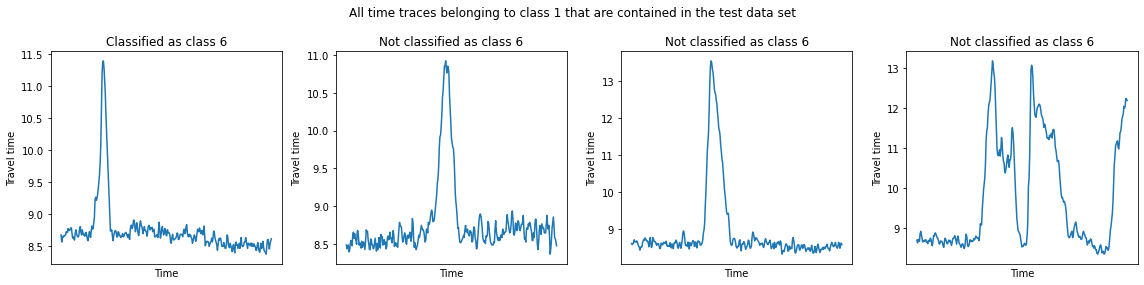

In [35]:
class_data = (y_test == 1)
class_index = class_data[class_data].index.to_list()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('All time traces belonging to class 1 that are contained in the test data set')
for i, index in enumerate(class_index):
    axes[i].plot(dataset.loc[index, X_var])
    axes[i].set_xticks([])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Travel time')
    axes[i].set_title('Classified as class 6') if index == 236 else axes[i].set_title('Not classified as class 6')

plt.tight_layout()
plt.show()

Here, it can be seen that, although the first three graphs look similar, only the first plot is classified as class 6. 
From this observation it can be concluded that there are three important features resulting in the false classification of class 1 to class 6:

    1. The low noise present in the low constant travel time (which is why plot 2 is not classified as class 6 and plot 1 is);
    2. The presence of a single peak, less than 11.5 in size (which is why plot 3 is not classified as class 6 and plot 1 is);
    3. A large part of the time trace is constant and a low value (which is why plot 4 is not classified as class 6).


## Task 4 - Feature Importance

QUESTION 12: Visualise one of the random tree. Comment on the tree structure

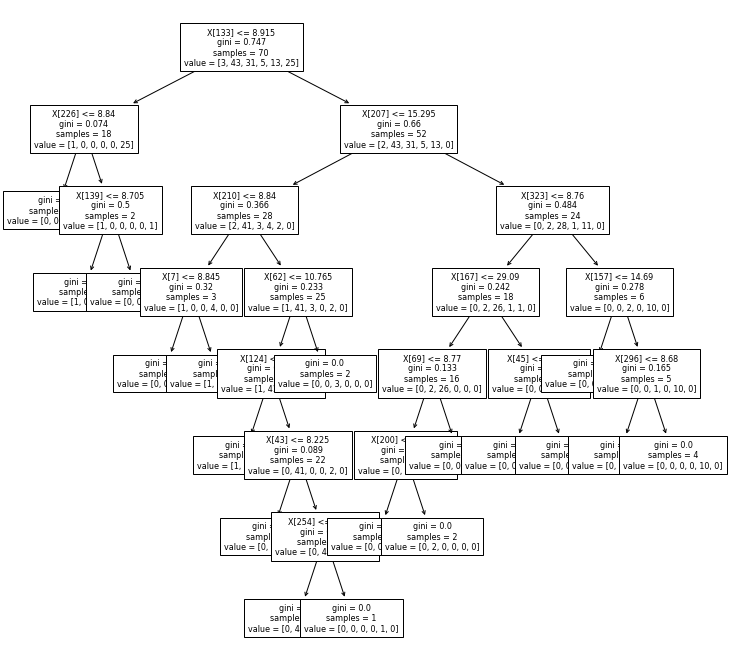

In [36]:
#Visualise one of the tree
from sklearn import tree
plt.figure(figsize=(12,12))
tree.plot_tree(clf.estimators_[10], fontsize=8) 
plt.show()

From the figure above, we can see that the tree structure is slightly unbalanced, indicating that the tree model does not overfit the data, but generalize diffenrent classes. 

The tree depth is about 8 layers, which is not very deep compared to the amount of labels we have. However, as we only have 6 classes, layers below 4th layers can be considered as overfitting, so we can ignore these layers. At 4th layer, Gini Index is around 0.2 ~ 0.3, which is small, indicating that the variance is not very high and the classification gives a good results.

Moreover, we can gain some information regarding the feature importance. From the tree structure, we can see that feature vector x[133] is the most important one, and then the x[226] and x[207]. It means that the data regarding these three feature dimensions can be further analyzed.

QUESTION 13: Analyse the random forest feature importance and comment on the findings.

The largest importance and corresponding feature value:  [(0.0226, 28.47), (0.0177, 27.5), (0.016, 28.17), (0.0142, 28.89), (0.0142, 28.1), (0.0139, 29.83), (0.0127, 21.17), (0.0127, 14.33), (0.012, 27.57), (0.0112, 27.99), (0.0111, 27.88), (0.0111, 21.69), (0.0109, 29.04), (0.0101, 14.54), (0.0095, 29.24), (0.0093, 27.39), (0.0092, 15.68), (0.0092, 14.51), (0.009, 28.91), (0.0087, 13.38), (0.0084, 16.48), (0.0083, 30.07), (0.0081, 27.81), (0.008, 28.94), (0.008, 14.6), (0.0079, 28.07), (0.0076, 29.04), (0.0075, 14.74), (0.0075, 14.39), (0.0073, 21.39)]


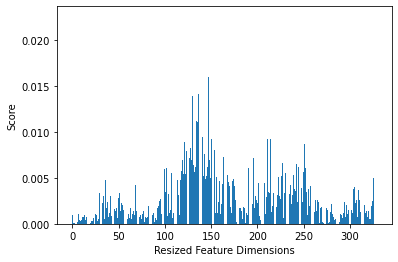

In [37]:
# get importance
Ypred_test = clf.predict(X_test)
importance = clf.feature_importances_

n=30
ranked = np.argsort(importance)
largest_indices = ranked[::-1][:n]

attributes = list(X.flatten())


a = sorted(zip(np.round(clf.feature_importances_,4), attributes), reverse=True)
print("The largest importance and corresponding feature value: ",a[:n])

plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Resized Feature Dimensions')
plt.ylabel('Score')
plt.show()

From the figure above, we can see that in the whole random forest tree structure, the most important feature vector is x[137], which is the peak of the figure, importance reaches the highest value 0.0226. We print out 30 largest importance index, feature value and importance value. From these we can see that feature value around 28, 20 and 14 have higher importance than others, indicating they are crutial to the classfication. From the raw data figures (plot of resized travel_time), it can be obtained that most of the important feature values are the highest values of travel_time (peak in the plot). As we already obtain from the data itself, one of the aspects of ditinguishing between different labels is the peak value. Hence, it explains why these feature vectors are important.



## Task 5 - Reflection

QUESTION 14: Given your analysis of the data, do you consider this a supervised classification problem or do you think it can also be solved as a unsupervised learning problem. (No need of coding. Just reflect!)

This problem is best considered a supervised classification problem. The various types of travel time plots were initially analysed to see emergent properties that belong to each known class. This would not have been possible in an unsupervised ML problem. The training of ML models were then also done in a supervised manner. As these models returned good classification results, it can be expected that by going the other way around, the true labels could be retrieved by using unsupervised ML methods.

In order to perform unsupervised ML classification, it is important to first investigate emergent patterns in the unclassified data. By knowing the emerging patterns, one can choose an adequate unsupervised ML method that can best distinguish between these patterns. If no such patterns would be present, performing unsupervised ML would be considered very difficult. 

As became clear from the time trace analysis of the data, there are various features that distinguish the different classes. Some of these features are:

- the number of travel time peaks;
- the duration of long travel time peaks;
- the variation in travel time;

By trying to cluster these kind of features, the true (supervised) labels could be retrieved, turning this classification problem into an unsupervised ML problem.